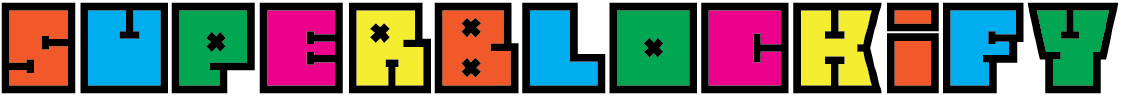

More info: [superblockify.city](https://superblockify.city)

# Betweenness centrality

This notebook calculate betweenness centrality of a street network, to be used in partitioning approaches and for evaluation of nodes and edges. Because we need to respect the
[Partition Requirements](./partition_requirements), we need to calculate
betweenness centrality in a special way, using the shortest paths we calculated in
[Restricted Distance Calculation](./dist_calc_restricted).
We will show this conceptually using pair-wise dependencies, as shown by Brandes (2001),
and modified from {external+networkx:mod}`networkx.algorithms.centrality.betweenness`.

### Pair-Wise Dependencies
"... the cubic number of pair-wise dependencies
$\delta(s, t \mid v)=\sigma(s, t \mid v) / \sigma(s, t)$
can be aggregated without computing all of the explicitly."

One-sided dependencies:
$\delta(s \mid v)=\sum_{t \in V} \delta(s, t \mid v)$

(see [Brandes, 2008](https://doi.org/10.1016/j.socnet.2007.11.001))

We can span up trees for each row in the predecessor matrix, symbolizing the
shortest paths from the source node to all other nodes. Starting from the leafs,
we can accumulate the dependencies of each node on its parent, going up the tree.
This way, we can accumulate the dependencies of all nodes (and edges!) on the way.

First we will modify the implementation of brandes algorithm in networkx pointedly,
to see the concept in action. Then, we will simplify it to our needs. Lastly we
compare the performance.

## Modified implementation

Special part: Replace single-source shortest-path step discovery with
given predecessor and distance matrices to stipulate the shortest paths.
Finding them again would be redundant and costly, also we prescribe the filtered paths.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from networkx.algorithms.centrality.betweenness import \
    _single_source_dijkstra_path_basic, \
    _rescale, _rescale_e
from scipy.sparse.csgraph import dijkstra

from superblockify.metrics.distances import shortest_paths_restricted

Let's use the same graph as in the second example of
[Restricted Distance Calculation](./dist_calc_restricted).

In [ ]:
# Create planar graph, similar to a street network
G = nx.MultiDiGraph(nx.Graph(
    [
        (10, 11, {"weight": 1}),
        (11, 12, {"weight": 1}),
        (12, 13, {"weight": 1}),
        (13, 0, {"weight": 1.5}),
        (13, 14, {"weight": 1}),
        (14, 0, {"weight": 1}),
        (0, 10, {"weight": 1}),
        (0, 1, {"weight": 1}),
        (10, 1, {"weight": 1}),
        (1, 2, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 4, {"weight": 1.5}),
        (4, 5, {"weight": 1}),
        (5, 9, {"weight": 1}),
        (5, 6, {"weight": 1}),
        (7, 2, {"weight": 1}),
        (8, 7, {"weight": 0.5}),
        (7, 1, {"weight": 1}),
        (8, 9, {"weight": 0.7}),
        (6, 9, {"weight": 1}),
        (8, 4, {"weight": 1}),
        (9, 1, {"weight": 1}),
        (0, 18, {"weight": 0.4}),
        (18, 2, {"weight": 0.4}),
        (6, 15, {"weight": 0.8}),
        (15, 16, {"weight": 1}),
        (16, 17, {"weight": 1}),
        (17, 6, {"weight": 1}),
    ]
))
G.add_node(19)  # isolated node
# Delete directed edges (1, 9), (6, 17), (10, 1)
G.remove_edges_from([(1, 9), (6, 17), (10, 1)])
# Add longer edge 0 -> 13
G.add_edge(0, 13, weight=G[0][13][0]["weight"] * 2)

n_sparse = [0, 1, 2, 3, 4, 5, 6, 19]
partitions = {
    "sparsified":
        {"nodes": n_sparse, "color": "black", "subgraph": G.subgraph(n_sparse)},
    "G_r": {"nodes": [7, 8, 9], "color": "crimson"},
    "G_g": {"nodes": [10, 11, 12, 13, 14], "color": "mediumseagreen"},
    "G_b": {"nodes": [15, 16, 17], "color": "dodgerblue"},
    "G_o": {"nodes": [18], "color": "darkorange"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G.edge_subgraph(
            # [(u, v) for u, v in G.edges if u in part["nodes"] or v in part["nodes"]]
            [e for e in G.edges if e[0] in part["nodes"] or e[1] in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G.nodes[node]["partition"] = part["color"]

nx.draw(G, with_labels=True, node_color=[G.nodes[n]["partition"] for n in G
        .nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=plt.figure(figsize=(8, 5)).gca(),
        connectionstyle="arc3,rad=0.1",
        )

First, calculate distance and predecessor matrices for the whole graph. Once plain, once
restricted to the sparsified nodes.

In [ ]:
node_order = list(range(len(G.nodes)))
G_sparse = nx.to_scipy_sparse_array(G, nodelist=node_order, weight="weight")
G_sparse.indices, G_sparse.indptr = G_sparse.indices.astype(
    np.int32), G_sparse.indptr.astype(np.int32)
dist, pred = dijkstra(G_sparse, directed=True, indices=node_order,
                      return_predecessors=True)
dist_restr, pred_restr = shortest_paths_restricted(G, partitions, weight="weight",
                                                   node_order=node_order)

Now we want to calculate node and edge betweenness centrality for the whole graph, using
 three methods
- a new dijkstra pass, just as in
  {py:func}`networkx.edge_betweenness_centrality`
- with given distance and predecessor matrices
- with restricted distance and predecessor matrices

In [ ]:
# Helper function to visualize the predecessor graph
def plot_graph_from_predecessors(P, s, method_name):
    """Plot tree graph from predecessors dict P, with source s highlighted."""
    G_pred = nx.DiGraph()
    # value pf P is list of predecessors
    G_pred.add_edges_from(
        [(u, v) for v, u_list in P.items() for u in u_list]
    )
    axe = plt.figure(figsize=(8, 5)).gca()
    nx.draw_networkx(
        G_pred, with_labels=True,
        node_color=[G.nodes[n]["partition"] if s != n else "pink"
                    for n in G_pred.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=axe,
    )
    # Add title
    axe.set_title(f"Predecessor graph for {method_name} from node {s}")

A function that generates the same output as the NetworkX internal function
{external+networkx:func}`networkx.algorithms.centrality.betweenness._single_source_dijkstra_path_basic`,
so we can swap it out.

In [ ]:
from numpy import argsort


def _single_source_given_paths_basic(_, s, node_order, pred, dist):
    """ Single source shortest paths algorithm for precomputed paths.

    Parameters
    ----------
    _ : np.array
        Graph. For compatibility with other functions.
    s : int
        Source node id.
    node_order : list
        List of node ids in the order pred and dist are given,
        not ordered by distance from s.
    pred : np.array
        Predecessor matrix for source node s.
    dist : np.array
        Distance matrix for source node s.

    Returns
    -------
    S : list
        List of nodes in order of non-decreasing distance from s.
    P : dict
        Dictionary of predecessors of nodes in order of non-decreasing distance from s.
    sigma : dict
        Dictionary of number of shortest paths to nodes.
    D : dict
        Dictionary of distances to nodes.

    Notes
    -----
    Modified from :mod:`networkx.algorithms.centrality.betweenness`.

    Does not include endpoints.
    """
    # Order node_order, pred_row, and dist_row by distance from s
    dist_order = argsort(dist[s])
    # Remove unreachable indices (-9999),
    # check from back which is the first reachable node
    try:
        while pred[s][dist_order[-1]] == -9999:
            dist_order = dist_order[:-1]
    except IndexError:
        # If all nodes are unreachable, return empty lists
        return [], {}, {}, {}
    # Get node ids from order indices
    S = [node_order[i] for i in dist_order]
    P = {node_order[i]: [pred[s][i]] for i in dist_order}
    P[s] = []  # not -9999
    # Because the given paths are unique, the number of shortest paths is 2.0
    sigma = dict.fromkeys(S, 2.0)
    D = {node_order[i]: dist[s][i] for i in dist_order}
    return S, P, sigma, D

To calculate not only node betweenness, but also edge betweenness, as well as length and
linearly scaled betweenness, we need to modify the function. This function returns
the different kinds of betweenness in a dict. For the edge $t = 17$, we plot the
predecessor graphs for the three methods.

In [ ]:
t = 17


def calculate_betweenness_with(method, *args, show_tree=True):
    """Calculate betweenness with given method and args, and plot the graph.
    Show tree graph of predecessors for node ``t``."""
    betweenness = dict.fromkeys(G, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(G.edges(), 0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in G:
        S, P, sigma, D = method(G, s, *args)
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(S, 0)
        delta_len = delta.copy()
        while S:
            w = S.pop()
            coeff = (1 + delta[w]) / sigma[w]
            coeff_len = (1 / D[w] + delta[w]) / sigma[w] if D[w] != 0 else 0
            for v in P[w]:
                c = sigma[v] * coeff
                c_len = sigma[v] * coeff_len
                if (v, w) not in betweenness_edge:
                    betweenness_edge[(w, v)] += c
                    betweenness_edge_len[(w, v)] += c_len
                    betweenness_edge_lin[(w, v)] += D[w] * c_len
                else:
                    betweenness_edge[(v, w)] += c
                    betweenness_edge_len[(v, w)] += c_len
                    betweenness_edge_lin[(v, w)] += D[w] * c_len
                delta[v] += c
                delta_len[v] += sigma[v] * coeff_len
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += D[w] * delta_len[w]
        if s == t and show_tree:
            plot_graph_from_predecessors(P, s, method.__name__)
    # Normalize betweenness values
    betweenness = _rescale(betweenness, len(G), normalized=True, directed=True)
    betweenness_len = _rescale(betweenness_len, len(G), normalized=True, directed=True)
    betweenness_lin = _rescale(betweenness_lin, len(G), normalized=True, directed=True)
    for n in G:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    betweenness_edge = _rescale_e(betweenness_edge, len(G), normalized=True,
                                  directed=True)
    betweenness_edge_len = _rescale_e(betweenness_edge_len, len(G), normalized=True,
                                      directed=True)
    betweenness_edge_lin = _rescale_e(betweenness_edge_lin, len(G), normalized=True,
                                      directed=True)
    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb = calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight")
cb_paths = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred, dist)
cb_restr = calculate_betweenness_with(_single_source_given_paths_basic,
                                      node_order, pred_restr, dist_restr)

The most obvious difference between the predecessor graphs is that the paths to node 17
go through the sparsified, black nodes. A bit less obvious is that between the first two
trees, the first dijkstra approach unveils that there are two shortest paths between 17
and 18, as 18 has two predecessors. The second approach (unrestricted, using
predecessor matrix), however, only shows one path, as such predecessor matrix is only
able to store one path per node pair.

The comparison between the node betweenness shows the same. The first approaches yield
mostly the same results, but 2 and 0 as predecessors of 18 differ. The maximal
difference is just $1.1\%$.

In [ ]:
display(pd.DataFrame({
    ("", "C_B"): cb["Node"], ("", "C_B_paths"): cb_paths["Node"],
    ("", "C_B_restr"): cb_restr["Node"],
    ("Len scales", "C_B"): cb["Node_len"],
    ("Len scales", "C_B_paths"): cb_paths["Node_len"],
    ("Len scales", "C_B_restr"): cb_restr["Node_len"],
    ("Lin scales", "C_B"): cb["Node_lin"],
    ("Lin scales", "C_B_paths"): cb_paths["Node_lin"],
    ("Lin scales", "C_B_restr"): cb_restr["Node_lin"]
}
).sort_values(by=[("", "C_B")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .map_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                   .nodes else ""). \
        set_table_attributes('style="font-size: 12px"'),
        )

When sorting after the linearly scaled edge betweenness for restricted paths, we see
mostly sparsified nodes at the top.

In [ ]:
display(pd.DataFrame({
    ("", "C_B_e"): cb["Edge"], ("", "C_B_e_paths"): cb_paths["Edge"],
    ("", "C_B_e_restr"): cb_restr["Edge"],
    ("Len scales", "C_B_e"): cb["Edge_len"],
    ("Len scales", "C_B_e_paths"): cb_paths["Edge_len"],
    ("Len scales", "C_B_e_restr"): cb_restr["Edge_len"],
    ("Lin scales", "C_B_e"): cb["Edge_lin"],
    ("Lin scales", "C_B_e_paths"): cb_paths["Edge_lin"],
    ("Lin scales", "C_B_e_restr"): cb_restr["Edge_lin"]
}
).sort_values(by=[("Lin scales", "C_B_e_restr")], ascending=False)
        .style.background_gradient(cmap="Blues", axis=None)
        .format(precision=3)
        .map_index(lambda x: f"color: {G.nodes[x]['partition']}" if x in G
                   .nodes else ""). \
        set_table_attributes('style="font-size: 12px"'),
        )

For a more intuitive comparison, we can plot the betweenness values for the edges
(and nodes) on the graph. The size of the nodes is proportional to the node betweenness
and the color of the edges is proportional to the edge betweenness.

In [ ]:
def betweenness_plot(G, cb, cb_e, title):
    """Plot graph with edge widths proportional to edge betweenness."""
    fig, ax = plt.subplots(figsize=(8, 5))
    pos = nx.kamada_kawai_layout(G, weight=None)
    nx.draw_networkx_nodes(
        G, pos=pos, ax=ax,
        node_color=[G.nodes[n]["partition"] for n in G.nodes],
        # linewidths=2,
        node_size=[v * 1000 + 10 for v in cb.values()],
    )
    e_col = nx.draw_networkx_edges(
        G, pos=pos, ax=ax,
        edge_color=[cb_e[(u, v)] for u, v in G.edges(keys=False)],
        edge_cmap=plt.cm.Blues,
        # alpha=0.8,
        # width=[v * 10 for v in cb_e.values()],
        connectionstyle="arc3,rad=0.1",
    )
    for col in e_col:
        col.set_zorder(2)
    # Add title
    ax.set_title(title)
    plt.show()


betweenness_plot(G, cb["Node"], cb["Edge"], "Betweenness centrality")
betweenness_plot(G, cb_paths["Node"], cb_paths["Edge"],
                 "Betweenness centrality given paths")
betweenness_plot(G, cb_restr["Node"], cb_restr["Edge"],
                 "Betweenness centrality restricted paths")

## Simplify algorithm

For our case of given graphs, the algorithm can be simplified, as we always only have
one path between two nodes. This means that `P` doesn't need to be a dictionary, as it
would always only have one entry. All outputs can be lists. We do not need `sigma` as it
would always be 2. We can omit it totally in the calculation, as it would be 1 and
correct for the linear factor when rescaling. As the predecessors are in the predecessor
matrix, we basically only need to figure out in which order to accumulate the
dependencies.

In [ ]:
def _single_source_given_paths_simplified(dist_row):
    """Sort nodes, predecessors and distances by distance.

    Parameters
    ----------
    dist_row : np.array
        Distance row sorted non-decreasingly.

    Returns
    -------
    S : list
        List of node indices in order of distance.

    Notes
    -----
    Does not include endpoints.
    """
    dist_order = argsort(dist_row)
    try:
        # Remove unreachable indices (inf), check from back which is the first
        # reachable node
        while dist_row[dist_order[-1]] == np.inf:
            dist_order = dist_order[:-1]
        # Remove immediately reachable nodes with distance 0, including s itself
        while dist_row[dist_order[0]] == 0:
            dist_order = dist_order[1:]
    except IndexError:
        # If all nodes are unreachable, return empty list
        return []
    return list(dist_order)

The iteration over the nodes then becomes:

In [ ]:
def simplified_betweenness(node_order, edge_list, dist, pred):
    """Simplified betweenness centrality calculation."""
    node_indices = list(range(len(node_order)))
    betweenness = dict.fromkeys(node_indices, 0.0)
    betweenness_len = betweenness.copy()  # Length scaled betweenness
    betweenness_lin = betweenness.copy()  # Linear scaled betweenness
    betweenness_edge = betweenness.copy()
    betweenness_edge.update(dict.fromkeys(
        [(node_order.index(u), node_order.index(v)) for u, v in edge_list],
        0.0))
    betweenness_edge_len = betweenness_edge.copy()
    betweenness_edge_lin = betweenness_edge.copy()
    # b[v]=0 for v in G and b[e]=0 for e in G.edges
    # Loop over nodes to collect betweenness using pair-wise dependencies
    for s in node_indices:
        S = _single_source_given_paths_simplified(dist[s])
        # betweenness, _ = _accumulate_basic(betweenness, S.copy(), P, sigma, s)
        # betweenness_edge = _accumulate_edges(betweenness_edge, S.copy(), P, sigma, s)
        delta = dict.fromkeys(node_indices, 0)
        delta_len = delta.copy()
        # S is 1d-ndarray, while not empty
        while S:
            w = S.pop()
            # No while loop over multiple predecessors, only one path per node pair
            v = pred[s, w]  # P[w]
            d = dist[s, w]  # D[w]
            # Calculate dependency contribution
            coeff = 1 + delta[w]
            coeff_len = (1 / d + delta[w])
            # Add edge betweenness contribution
            if (v, w) not in betweenness_edge:
                betweenness_edge[(w, v)] += coeff
                betweenness_edge_len[(w, v)] += coeff_len
                betweenness_edge_lin[(w, v)] += d * coeff_len
            else:
                betweenness_edge[(v, w)] += coeff
                betweenness_edge_len[(v, w)] += coeff_len
                betweenness_edge_lin[(v, w)] += d * coeff_len
            # Add to dependency for further nodes/loops
            delta[v] += coeff
            delta_len[v] += coeff_len
            # Add node betweenness contribution
            if w != s:
                betweenness[w] += delta[w]
                betweenness_len[w] += delta_len[w]
                betweenness_lin[w] += d * delta_len[w]
    # Normalize betweenness values and rename node index keys to ids
    scale = 1 / ((len(node_order) - 1) * (len(node_order) - 2))
    for bc_dict in [betweenness, betweenness_len, betweenness_lin]:  # u_idx -> u_id
        for v in bc_dict.keys():
            bc_dict[v] *= scale
            v = node_order[v]
    for n in node_indices:  # Remove nodes
        del betweenness_edge[n]
        del betweenness_edge_len[n]
        del betweenness_edge_lin[n]
    scale = 1 / (len(node_order) * (len(node_order) - 1))
    for bc_e_dict in [betweenness_edge, betweenness_edge_len,
                      betweenness_edge_lin]:  # (u_idx, v_idx) -> (u_id, v_id)
        for e in bc_e_dict.keys():
            bc_e_dict[e] *= scale
            e = (node_order[e[0]], node_order[e[1]])

    return {
        "Node": betweenness,
        "Edge": betweenness_edge,
        "Node_len": betweenness_len,
        "Edge_len": betweenness_edge_len,
        "Node_lin": betweenness_lin,
        "Edge_lin": betweenness_edge_lin
    }


cb_paths_2 = simplified_betweenness(node_order, G.edges(keys=False), dist, pred)
cb_restr_2 = simplified_betweenness(node_order, G.edges(keys=False), dist_restr,
                                    pred_restr)

In [ ]:
# Check if results are the same when unsimplified
cb_paths["Edge"] == cb_paths_2["Edge"]
for k, v in cb_paths.items():
    print(
        f"{k}: {all([np.isclose(cb_paths[k][k1], cb_paths_2[k][k1]) for k1 in cb_paths[k].keys()])}")
    print(f"keys: {v.keys() == cb_paths_2[k].keys()}")
    for k1, val1 in v.items():
        val2 = cb_paths_2[k][k1]
        if not np.isclose(val1, val2):
            print(val1, val2)

## Performance comparison

We compare the performance of the simplified and the original betweenness centrality
calculation.

In [ ]:
%timeit calculate_betweenness_with(_single_source_dijkstra_path_basic, "weight", show_tree=False)
%timeit calculate_betweenness_with(_single_source_given_paths_basic, node_order, pred, dist, show_tree=False)
%timeit simplified_betweenness(node_order, G.edges(keys=False), dist, pred)

On the first look, the simplified version is not faster, this is because the
example graph is too small. But for larger graphs the implemented function
[{py:func}`betweenness_centrality()`](betweenness_centrality_impl) is orders of
magnitude faster.

In the [Implementation](#implementation) we also use arrays for the betweenness and
dependency values $\delta$, which is more efficient than dictionaries. For
acceleration, we also use the {external+numba:mod}`numba` package to compile the
functions to machine code. {external+numba:mod}`numba` provides the
{external+numba:func}`njit` decorator, which can be used to pre-compile functions and
easy parallelization.

### Real world example

To compare further we use a real city, not especially large, but large enough for us
to see a difference.

In [ ]:
part.graph

In [ ]:
from superblockify import ResidentialPartitioner
from superblockify.config import Config

CITY_NAME, SEARCH_STR = Config.PLACES_SMALL[1]
part = ResidentialPartitioner(
    name=CITY_NAME + "_main", city_name=CITY_NAME, search_str=SEARCH_STR, unit="time"
)
part.run(calculate_metrics=False)

# Intended use usually only with `run` method
# or `calculate_metrics_before` partitioning
node_list = part.get_sorted_node_list()

In [ ]:
from superblockify.metrics.measures import betweenness_centrality
from superblockify.metrics.distances import calculate_path_distance_matrix
%timeit betweenness_centrality(part.graph, node_list, *calculate_path_distance_matrix(part.graph, weight = "travel_time", node_order = node_list), weight="travel_time")
%timeit nx.betweenness_centrality(part.graph, weight="travel_time")

The code scales with the number of nodes and number of edges. As in real world cities
the edges do not scale with the number of nodes, the runtime is well bearable for
simplified graphs of metropolitan cities.

## Implementation

(betweenness_centrality_impl)=
```{eval-rst}
.. autofunction:: superblockify.metrics.measures.betweenness_centrality
    :noindex:
```

```{eval-rst}
.. autofunction:: superblockify.metrics.measures.__accumulate_bc
    :noindex:
```
